# Satellite images segmentation

The task consists of creating a neural model able to perform semantic segmentation on satellite images into six (seven with the no information) different classes. The data used in this project is extracted from the [IGN](https://geoservices.ign.fr/telechargement) archives, and can be downloaded [here](https://drive.google.com/file/d/1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem/view?usp=sharing).

Each tile in the dataset has a 1000x1000 resolution representing a 500m x 500m footprint (the resolution is 50cm per pixel).

The file structure of the dataset is as follows:
```none
├── ign
│   ├── annotations
│   │   ├── training
│   │   │   ├── aaa.png
│   │   │   ├── bbb.png
│   │   ├── validation
│   │   │   ├── xxx.png
│   │   │   ├── yyy.png
│   ├── images
│   │   ├── training
│   │   │   ├── aaa.png
│   │   │   ├── bbb.png
│   │   ├── validation
│   │   │   ├── xxx.png
│   │   │   ├── yyy.png

```

Here is an example of the image/mask contained in the dataset: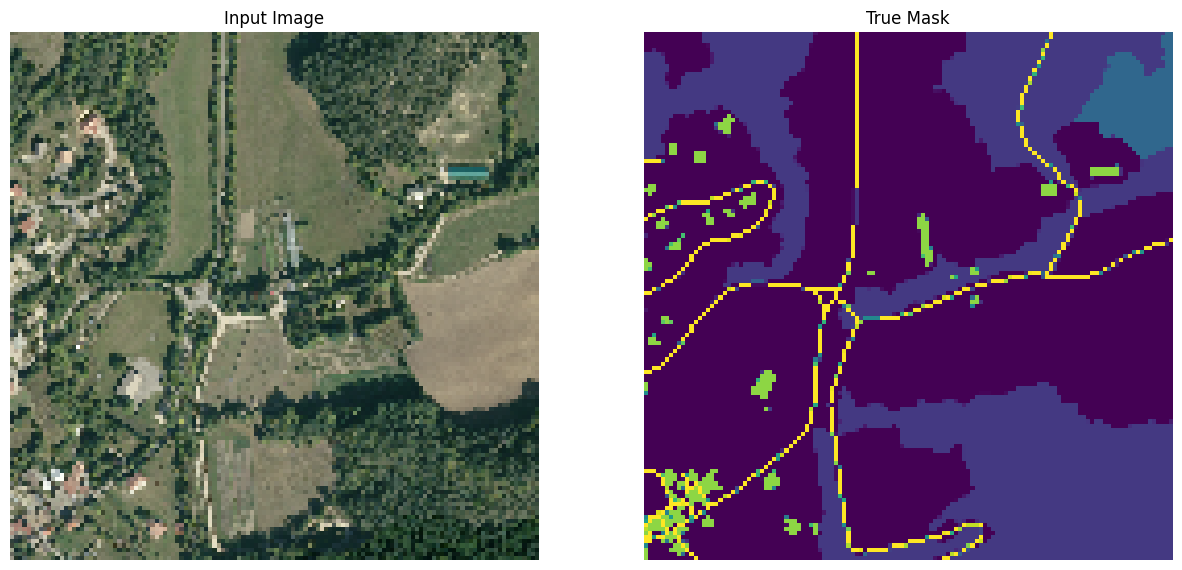

HINT: If the data does not fit into the memory, try by patching the image into smaller portions.

## Downloading the data

The data can be either downloaded from the link above and uploaded directly on Colab, or by running the following code snippet, that automatically downloads the data and unzip it.

In [ ]:
#!gdown 1y73mUPzS5Hhq1RjPXc9bxch-Nv6HlJem
#!unzip ign_dataset.zip
#!rm ign_dataset.zip

from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/deep_learning/esame_luglio/ign_dataset.zip ./
!unzip ign_dataset.zip

Mounted at /content/drive
Archive:  ign_dataset.zip
   creating: ign/
   creating: ign/annotations/
   creating: ign/annotations/training/
  inflating: ign/annotations/training/c0_0915_6395.png  
  inflating: ign/annotations/training/c0_0920_6390.png  
  inflating: ign/annotations/training/c0_0935_6390.png  
  inflating: ign/annotations/training/c0_0935_6400.png  
  inflating: ign/annotations/training/c0_0955_6380.png  
  inflating: ign/annotations/training/c0_0960_6390.png  
  inflating: ign/annotations/training/c0_0975_6425.png  
  inflating: ign/annotations/training/c0_0990_6405.png  
  inflating: ign/annotations/training/c10_0915_6395.png  
  inflating: ign/annotations/training/c10_0920_6390.png  
  inflating: ign/annotations/training/c10_0935_6390.png  
  inflating: ign/annotations/training/c10_0935_6400.png  
  inflating: ign/annotations/training/c10_0955_6380.png  
  inflating: ign/annotations/training/c10_0960_6390.png  
  inflating: ign/annotations/training/c10_0975_6425.png  

## Multi-class segmentation

In this project, the input-target pair is composed by a $1000 \times 1000$ RGB image as visualized above, together with a $1000 \times 1000$ mask, that classifies each pixel by assigning to it a real number.

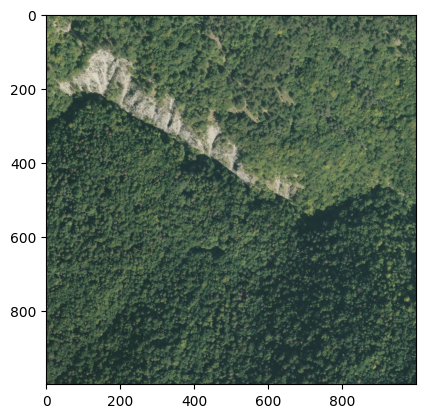

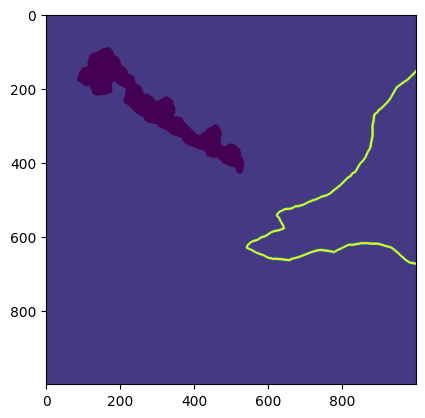

Shape of x: (1000, 1000, 3). Shape of y: (1000, 1000).
Unique values of y: [0.         0.00392157 0.02352941].


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import os
import glob

X_path = './ign/images/'
Y_path = './ign/annotations/'

train_name = sorted(os.listdir(os.path.join(X_path, 'training')))
test_name = sorted(os.listdir(os.path.join(X_path, 'validation')))

# As an example: load a sample to check the data
x_sample = plt.imread(os.path.join(X_path, 'training', train_name[10]))
y_sample = plt.imread(os.path.join(Y_path, 'training', train_name[10]))
plt.imshow(x_sample)
plt.show()
plt.imshow(y_sample)
plt.show()

print(f"Shape of x: {x_sample.shape}. Shape of y: {y_sample.shape}.")
print(f"Unique values of y: {np.unique(y_sample)}.")

In the example above, $\texttt{y_sample}$ contains 3 classes, represented by the three unique real numbers $[0, 0.00392157, 0.02352941]$.

Note that this approach is unusual in multiclass segmentation, where usually the mask is reshaped to be an $height \times width \times num. class$ binary array, where the pixel in position $(i, j)$ is classified as the class associated to the value 1, among the channels.

In this project, we assume that your data is processed as described above, since the metric used for the evaluation is implemented this way.  

## Metrics
The comparison metric for this project is the Dice Cofficient for multi-class segmentation (see the Lab about Segmentation for more informations). To apply this function, you are required to reshape both the predicted mask and the true mask to shape $\texttt{(batch_size, h, w, num_classes)}$, where $\texttt{num_classes}$ is the number of segmentation classes.

**IMPORTANT**: Remember to leave a print of average Dice Coefficient among the test set on the Notebook for a comparison. To do that, just measure the Dice Coffient by using the functions below for each batch, and take the average.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice/numLabels

## Project implementation

Good luck!

Some useful imports and constants

In [ ]:
!pip install patchify
from patchify import patchify
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import random
import keras as ks
import keras.backend as K
import tensorflow as tf
import os
import glob
import tensorflow.keras as ks
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import Image

DEST_BASE_DIR = './ign_patched/'
BASE_DIR = './ign/'
PATCH_SIZE = 224
BATCH_SIZE = 32
N_CLASSES = 7

## Data preprocessing
As suggested by the assignment, I decided to use patches. The chosen size is 224x224. This choice ensures that I can define 16 patches from each image available in the initial dataset, resulting in 9600 images and masks for training, and 3200 for validation. Additionally, by using batches of size 32, I can define 300 of them for the training set and 100 for the test set. This choice is motivated by the fact that a smaller image size like 224x224 reduces the computational load on the model during training, It's a size that has been used in the past to train well known architectures (such as AlexNet or VGG, for example) and allows downsampling through the use of multiple pooling layers.



In [ ]:
def setup_directories(base_dir, dest_base_dir):
    if not os.path.exists(dest_base_dir):
        os.makedirs(os.path.join(dest_base_dir, 'train', 'images'))
        os.makedirs(os.path.join(dest_base_dir, 'train', 'masks'))
        os.makedirs(os.path.join(dest_base_dir, 'val', 'images'))
        os.makedirs(os.path.join(dest_base_dir, 'val', 'masks'))
    else:
        print(f"Folder {dest_base_dir} already exists")

def process_images(base_dir, dest_base_dir, folder_pairs, patch_size):
    if len(os.listdir(os.path.join(dest_base_dir, 'train', 'images'))) == 0:
        for src_folder, dest_folder in folder_pairs:
            for path, _, files in os.walk(os.path.join(base_dir, src_folder)):
                dirname = os.path.basename(path)
                print(dirname)
                for index, image_name in enumerate(files):
                    if image_name.endswith('.png'):
                        process_image(path, image_name, dirname, dest_base_dir, dest_folder, patch_size)
                        if index % 100 == 99:
                            print(f"Processing image number: {index + 1}")
    else:
        print('Patching already done')

def process_image(path, image_name, dirname, dest_base_dir, dest_folder, patch_size):
    image_path = os.path.join(path, image_name)
    image = cv2.imread(image_path)
    size_x = (image.shape[1] // patch_size) * patch_size
    size_y = (image.shape[0] // patch_size) * patch_size

    image = Image.fromarray(image).crop((0, 0, size_x, size_y))
    image = np.array(image)

    patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = np.squeeze(patches_img[i, j, ...])
            destination_folder = 'val' if dirname == 'validation' else 'train'
            save_patch(single_patch_img, dest_base_dir, destination_folder, dest_folder, image_name, i, j)

def save_patch(patch, dest_base_dir, dest_folder, subfolder, image_name, i, j):
    patch_path = os.path.join(dest_base_dir, dest_folder, subfolder, f"{image_name[:-4]}_patch_{i}_{j}.tif")
    cv2.imwrite(patch_path, patch)


folder_pairs = [['images', 'images'], ['annotations', 'masks']]
# Setup directories and process images
setup_directories(BASE_DIR, DEST_BASE_DIR)
process_images(BASE_DIR, DEST_BASE_DIR, folder_pairs, PATCH_SIZE)


images
training
Processing image number: 100
Processing image number: 200
Processing image number: 300
Processing image number: 400
Processing image number: 500
Processing image number: 600
validation
Processing image number: 100
Processing image number: 200
annotations
training
Processing image number: 100
Processing image number: 200
Processing image number: 300
Processing image number: 400
Processing image number: 500
Processing image number: 600
validation
Processing image number: 100
Processing image number: 200


In [ ]:
class DataGenerator(ks.utils.Sequence):
    def __init__(self, folder_path, names, set_type, batch_size, shuffle=True):
        self.x_folder_path = os.path.join(folder_path, set_type, 'images')
        self.y_folder_path = os.path.join(folder_path, set_type, 'masks')
        self.names = names
        self.batch_size = batch_size
        self.shuffle = shuffle

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.names)

    def __getitem__(self, index):
        batch_names = self.names[index * self.batch_size : (index+1) * self.batch_size]
        x_batch = np.asarray([self.__get_input(os.path.join(self.x_folder_path, img_name)) for img_name in batch_names])
        y_batch = np.asarray([self.__get_output(os.path.join(self.y_folder_path, img_name)) for img_name in batch_names])
        return x_batch, y_batch

    def __len__(self):
        return len(self.names) // self.batch_size

    def __get_input(self, path):
        image = ks.utils.load_img(path)
        image_arr = ks.utils.img_to_array(image)
        return image_arr

    def __get_output(self, path):
        image = ks.utils.load_img(path, color_mode='grayscale')
        image_arr = ks.utils.img_to_array(image)
        return ks.utils.to_categorical(image_arr, num_classes=N_CLASSES)

In [ ]:
train_images = sorted(os.listdir(os.path.join(DEST_BASE_DIR, 'train', 'images')))
test_images = sorted(os.listdir(os.path.join(DEST_BASE_DIR, 'val', 'images')))
traingen = DataGenerator(folder_path=DEST_BASE_DIR,names=train_images,set_type='train',batch_size = BATCH_SIZE)
valgen = DataGenerator(folder_path=DEST_BASE_DIR,names=test_images,set_type='val',batch_size = BATCH_SIZE)
num_train_batches = len(traingen)
num_val_batches = len(valgen)
print(f'Number of training batches: {num_train_batches}')
print(f'Number of validation batches: {num_val_batches}')
x_ex, y_ex = traingen[0]
print(f"images batch shape: {x_ex.shape}")
print(f"masks batch shape: {y_ex.shape}")


Number of training batches: 300
Number of validation batches: 100
images batch shape: (32, 224, 224, 3)
masks batch shape: (32, 224, 224, 7)


Plot of some images and their masks

In [ ]:
colors = [[128, 0, 128],[0, 0, 255],[135, 206, 235],[204, 119, 34],[255, 192, 203],[199, 21, 133],[0, 0, 139]]

def create_color_image(y, colors):
    if y is None:
        return None
    classes_index = np.argmax(y, axis=-1)
    color_image = np.zeros((classes_index.shape[0], classes_index.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        color_image[classes_index == i] = color
    return color_image

def plot(x, y_true, y_pred=None):
    ys_img = [create_color_image(y_true, colors), create_color_image(y_pred, colors)] # I use it also during the training to plot some predictions

    fig, axes = plt.subplots(1, len([y for y in ys_img if y is not None]) + 1, figsize=(8,12))

    axes[0].imshow(x.astype(np.uint8))
    axes[0].set_title("Input")
    axes[0].axis('off')

    titles = ["Ground Truth Mask", "Predicted Mask"]
    for i, img in enumerate(ys_img):
        if img is not None:
            axes[i + 1].imshow(img)
            axes[i + 1].set_title(titles[i])
            axes[i + 1].axis('off')
    plt.show()
    plt.close()

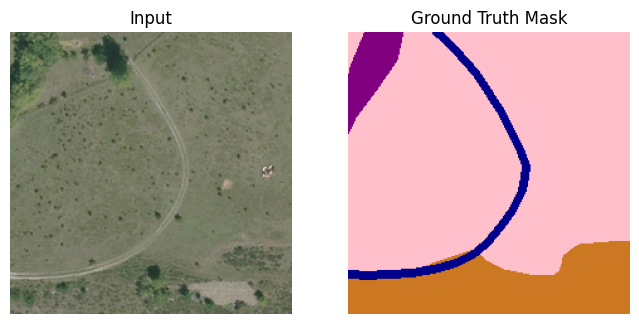

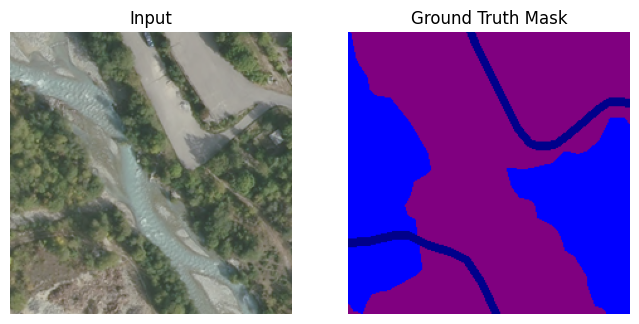

In [ ]:
for i in range(2):
    j = random.randint(0, len(train_images) - 1)
    x = plt.imread(os.path.join(DEST_BASE_DIR, 'train', 'images', train_images[j]))
    y = ks.utils.img_to_array(ks.utils.load_img(os.path.join(DEST_BASE_DIR, 'train', 'masks', train_images[j]), color_mode='grayscale'))
    plot(x, ks.utils.to_categorical(y, num_classes=7))

## Custom loss
In accordance with the assignment's requirements, the metric that i used to evaluate the results is the Dice coefficient. For training, two different loss functions were tested: categorical cross-entropy and the Dice_Multilabel_Loss (simply defined as 1 - Dice_Coef_Multilabel). The latter allowed the model to achieve better results in terms of both accuracy and training speed.



In [ ]:
from tensorflow.keras.losses import categorical_crossentropy

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=7):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[...,index], y_pred[...,index])
    return dice/numLabels

def dice_multilabel_loss(y_true, y_pred, numLabels=7):
    return 1. - dice_coef_multilabel(y_true, y_pred)

## Callback
The definition of DisplayCallback allows for visualizing some predictions during training. I used the callback to visualize some predictions during training, to use the early stopping, to decrease the learning rate and to save the optimal model weights.

In [ ]:
class DisplayCallback(Callback):
    def __init__(self, epoch_interval=2, num_images=5, test_names=None):
        super(DisplayCallback, self).__init__()
        self.epoch_interval = epoch_interval
        self.num_images = num_images
        self.test_names = test_names

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and (epoch + 1) % self.epoch_interval == 0:
            for _ in range(self.num_images):
                name = random.choice(self.test_names)
                x_path = os.path.join(DEST_BASE_DIR, 'val', 'images', name)
                y_path = os.path.join(DEST_BASE_DIR, 'val', 'masks', name)

                x_img = np.array(Image.open(x_path))
                x = ks.utils.img_to_array(ks.utils.load_img(x_path))

                y = ks.utils.img_to_array(ks.utils.load_img(y_path, color_mode='grayscale'))
                y_true = ks.utils.to_categorical(y, num_classes=N_CLASSES)

                y_pred = np.squeeze(self.model.predict(np.expand_dims(x, axis=0)))

                plot(x_img, y_true, y_pred)
                print(f"Dice coefficient multilabel of prediction: {dice_coef_multilabel(y_true, y_pred)}")

callbacks = [
    DisplayCallback(epoch_interval=8, num_images=4, test_names=test_images),
    EarlyStopping(monitor='val_dice_coef_multilabel',patience=10,min_delta=1e-4,mode='max',verbose=1),
    ReduceLROnPlateau(monitor='val_loss',patience=8,mode='min',verbose=1),
    ModelCheckpoint(filepath='../working/cp.ckpt',monitor='val_dice_coef_multilabel',save_best_only=True,save_weights_only=True,mode='max',verbose=1)
]

## Model
After trying various configurations of U-Net, well known for being optimal in segmentation tasks, I chose the one where I defined the encoder and decoder to be composed of 3 blocks, starting with a number of filters equal to 16. This configuration has approximately 300,000 parameters. I also tried a deeper configuration with 4 blocks (around one million parameters) and using more filters but these choices significantly increased the training time. I also removed the dropout layers because I tried using them, but I noticed that they slowed down the training and altered the dice coefficient value on the validation set.

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization, Rescaling, RandomFlip, Dropout
from keras.layers import concatenate, add
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2

def encoder(x, filters, n_block, kernel_size=(3, 3), activation='relu', batchnorm=False, dropout_rate=0.5):
    skip = []
    for i in range(n_block):
        x1 = Conv2D(filters, kernel_size, activation=activation, padding='same', kernel_initializer="he_normal",kernel_regularizer=l2(1e-4))(x)
        x1 = BatchNormalization()(x1) if batchnorm else x1
        x2 = Conv2D(filters, kernel_size, activation=activation, padding='same', kernel_initializer="he_normal",kernel_regularizer=l2(1e-4))(x1)
        x2 = BatchNormalization()(x2) if batchnorm else x2

        skip.append(x2)
        x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x2)
        #x = Dropout(dropout_rate)(x)
        filters *= 2
    return x, skip

def bottleneck(x, filters_bottleneck, depth=1, kernel_size=(3, 3), activation='relu', batchnorm=False, dropout_rate=0.5):
    for _ in range(depth):
        x1 = Conv2D(filters_bottleneck, kernel_size, activation=activation, padding='same', kernel_initializer="he_normal",kernel_regularizer=l2(1e-4))(x)
        x1 = BatchNormalization()(x1) if batchnorm else x1
        x2 = Conv2D(filters_bottleneck, kernel_size, activation=activation, padding='same', kernel_initializer="he_normal",kernel_regularizer=l2(1e-4))(x1)
        x2 = BatchNormalization()(x2) if batchnorm else x2

        #x = Dropout(dropout_rate)(x2)
        x = x2
    return x

def decoder(x, skip, filters, n_block, kernel_size=(3, 3), activation='relu', batchnorm=False, dropout_rate=0.5):
    for i in reversed(range(n_block)):
        x = UpSampling2D(size=(2, 2))(x)
        filters //= 2
        x = Conv2D(filters, kernel_size, activation=activation, padding='same', kernel_initializer="he_normal",kernel_regularizer=l2(1e-4))(x)
        x = BatchNormalization()(x) if batchnorm else x
        x = concatenate([skip[i], x])

        x1 = Conv2D(filters, kernel_size, activation=activation, padding='same', kernel_initializer="he_normal",kernel_regularizer=l2(1e-4))(x)
        x1 = BatchNormalization()(x1) if batchnorm else x1
        x2 = Conv2D(filters, kernel_size, activation=activation, padding='same', kernel_initializer="he_normal",kernel_regularizer=l2(1e-4))(x1)
        x2 = BatchNormalization()(x2) if batchnorm else x2
        #x = Dropout(dropout_rate)(x2)
        x = x2
    return x

def unet(input_shape=(224, 224, 3), filters=16, batchnorm=False, n_block=3, depth=1,loss=dice_multilabel_loss, learning_rate=0.001, dropout_rate=0.3, N_CLASSES=7):
    input = Input(input_shape)
    input = Rescaling(scale=1./255.)(input)
    #Augmentation
    input = RandomFlip(mode="horizontal_and_vertical", seed=24)(input)

    encod, skip = encoder(input, filters, n_block, batchnorm=batchnorm, dropout_rate=dropout_rate)
    bot_neck = bottleneck(encod, filters * 2**n_block, depth=depth, batchnorm=batchnorm, dropout_rate=dropout_rate)
    decod = decoder(bot_neck, skip, filters, n_block, batchnorm=batchnorm, dropout_rate=dropout_rate)

    classify = Conv2D(N_CLASSES, (1, 1), activation='softmax')(decod)

    model = Model(inputs=input, outputs=classify)
    model.compile(optimizer=Adam(learning_rate), loss=loss, metrics=[dice_coef_multilabel, 'accuracy'])
    return model

model6 = unet(input_shape=(224, 224, 3), filters=16, batchnorm=True, loss=dice_multilabel_loss)
model6.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 16)         64        ['conv2d[1][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 16)         2320      ['batch_normalization[1][0

## Training and Results

Epoch 1/100
300/300 [==============================] - ETA: 0s - loss: 0.8972 - dice_coef_multilabel: 0.1304 - accuracy: 0.5214
Epoch 1: val_dice_coef_multilabel improved from -inf to 0.14662, saving model to ../working/cp.ckpt
300/300 [==============================] - 98s 260ms/step - loss: 0.8972 - dice_coef_multilabel: 0.1304 - accuracy: 0.5214 - val_loss: 0.8680 - val_dice_coef_multilabel: 0.1466 - val_accuracy: 0.4896 - lr: 0.0010
Epoch 2/100
300/300 [==============================] - ETA: 0s - loss: 0.7746 - dice_coef_multilabel: 0.2387 - accuracy: 0.6662
Epoch 2: val_dice_coef_multilabel improved from 0.14662 to 0.26871, saving model to ../working/cp.ckpt
300/300 [==============================] - 79s 263ms/step - loss: 0.7746 - dice_coef_multilabel: 0.2387 - accuracy: 0.6662 - val_loss: 0.7442 - val_dice_coef_multilabel: 0.2687 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 3/100
300/300 [==============================] - ETA: 0s - loss: 0.7301 - dice_coef_multilabel: 0.2830 - accu

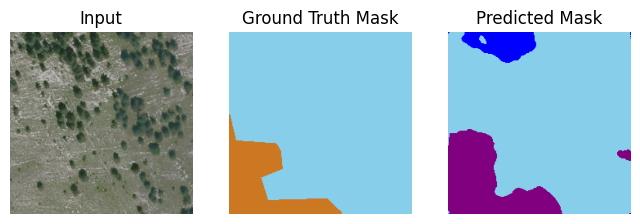

Dice coefficient multilabel of prediction: 0.17899124324321747
1/1 [==============================] - 0s 21ms/step


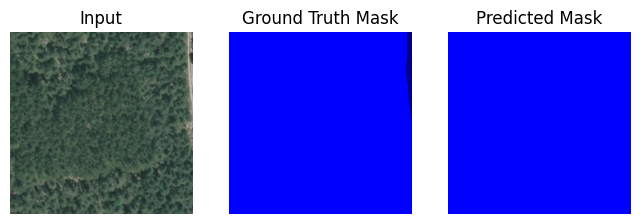

Dice coefficient multilabel of prediction: 0.1442965567111969
1/1 [==============================] - 0s 21ms/step


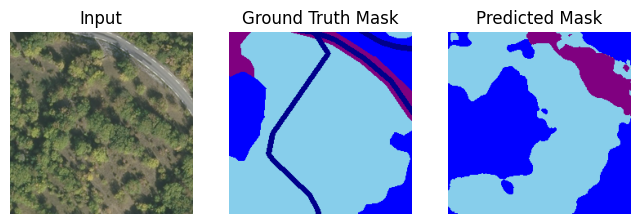

Dice coefficient multilabel of prediction: 0.20699100196361542
1/1 [==============================] - 0s 22ms/step


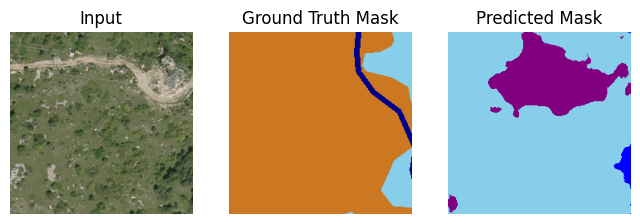

Dice coefficient multilabel of prediction: 0.033015672117471695

Epoch 8: val_dice_coef_multilabel improved from 0.29670 to 0.30861, saving model to ../working/cp.ckpt
300/300 [==============================] - 81s 270ms/step - loss: 0.7029 - dice_coef_multilabel: 0.3083 - accuracy: 0.7130 - val_loss: 0.7023 - val_dice_coef_multilabel: 0.3086 - val_accuracy: 0.7323 - lr: 0.0010
Epoch 9/100
300/300 [==============================] - ETA: 0s - loss: 0.7001 - dice_coef_multilabel: 0.3108 - accuracy: 0.7149
Epoch 9: val_dice_coef_multilabel did not improve from 0.30861
300/300 [==============================] - 79s 263ms/step - loss: 0.7001 - dice_coef_multilabel: 0.3108 - accuracy: 0.7149 - val_loss: 0.7041 - val_dice_coef_multilabel: 0.3067 - val_accuracy: 0.7346 - lr: 0.0010
Epoch 10/100
300/300 [==============================] - ETA: 0s - loss: 0.6961 - dice_coef_multilabel: 0.3145 - accuracy: 0.7186
Epoch 10: val_dice_coef_multilabel did not improve from 0.30861
300/300 [=============

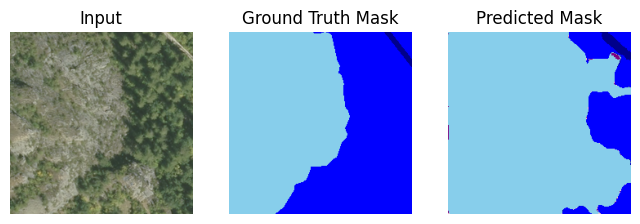

Dice coefficient multilabel of prediction: 0.259175568819046
1/1 [==============================] - 0s 22ms/step


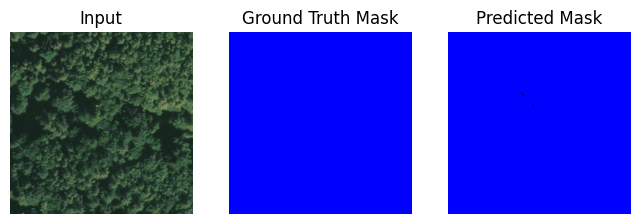

Dice coefficient multilabel of prediction: 0.14849118888378143
1/1 [==============================] - 0s 23ms/step


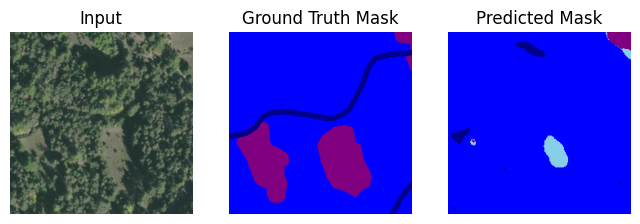

Dice coefficient multilabel of prediction: 0.1546521931886673
1/1 [==============================] - 0s 23ms/step


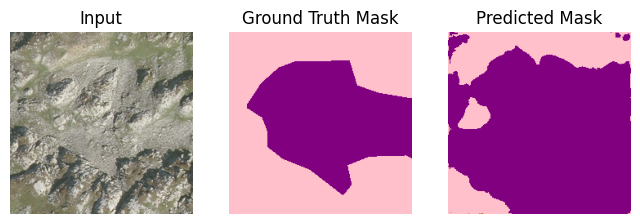

Dice coefficient multilabel of prediction: 0.2674867510795593

Epoch 16: val_dice_coef_multilabel improved from 0.39559 to 0.41933, saving model to ../working/cp.ckpt
300/300 [==============================] - 81s 271ms/step - loss: 0.5680 - dice_coef_multilabel: 0.4491 - accuracy: 0.7665 - val_loss: 0.5981 - val_dice_coef_multilabel: 0.4193 - val_accuracy: 0.7319 - lr: 0.0010
Epoch 17/100
300/300 [==============================] - ETA: 0s - loss: 0.5512 - dice_coef_multilabel: 0.4670 - accuracy: 0.7724
Epoch 17: val_dice_coef_multilabel did not improve from 0.41933
300/300 [==============================] - 79s 264ms/step - loss: 0.5512 - dice_coef_multilabel: 0.4670 - accuracy: 0.7724 - val_loss: 0.6037 - val_dice_coef_multilabel: 0.4151 - val_accuracy: 0.7140 - lr: 0.0010
Epoch 18/100
300/300 [==============================] - ETA: 0s - loss: 0.5413 - dice_coef_multilabel: 0.4775 - accuracy: 0.7751
Epoch 18: val_dice_coef_multilabel did not improve from 0.41933
300/300 [============

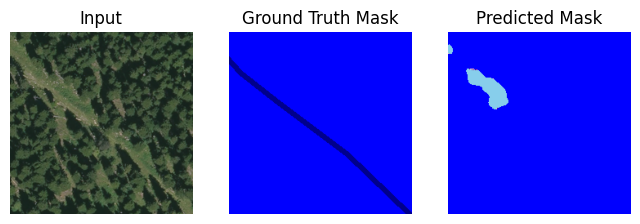

Dice coefficient multilabel of prediction: 0.13927994668483734
1/1 [==============================] - 0s 22ms/step


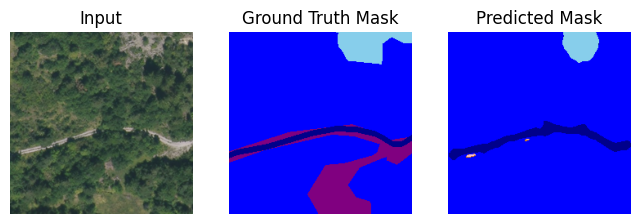

Dice coefficient multilabel of prediction: 0.3439582288265228
1/1 [==============================] - 0s 22ms/step


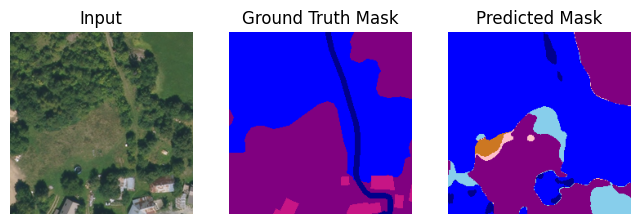

Dice coefficient multilabel of prediction: 0.25064295530319214
1/1 [==============================] - 0s 22ms/step


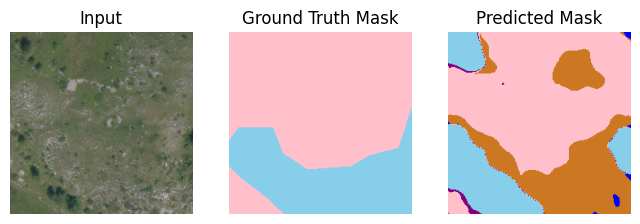

Dice coefficient multilabel of prediction: 0.18759821355342865

Epoch 24: val_dice_coef_multilabel improved from 0.46430 to 0.47090, saving model to ../working/cp.ckpt
300/300 [==============================] - 79s 263ms/step - loss: 0.5147 - dice_coef_multilabel: 0.5058 - accuracy: 0.7862 - val_loss: 0.5499 - val_dice_coef_multilabel: 0.4709 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 25/100
300/300 [==============================] - ETA: 0s - loss: 0.5095 - dice_coef_multilabel: 0.5114 - accuracy: 0.7895
Epoch 25: val_dice_coef_multilabel improved from 0.47090 to 0.49570, saving model to ../working/cp.ckpt
300/300 [==============================] - 79s 262ms/step - loss: 0.5095 - dice_coef_multilabel: 0.5114 - accuracy: 0.7895 - val_loss: 0.5252 - val_dice_coef_multilabel: 0.4957 - val_accuracy: 0.7968 - lr: 0.0010
Epoch 26/100
300/300 [==============================] - ETA: 0s - loss: 0.5096 - dice_coef_multilabel: 0.5113 - accuracy: 0.7895
Epoch 26: val_dice_coef_multilabel did not i

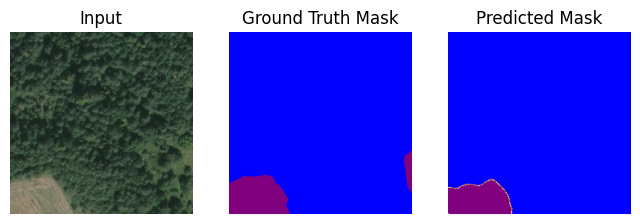

Dice coefficient multilabel of prediction: 0.31242936849594116
1/1 [==============================] - 0s 24ms/step


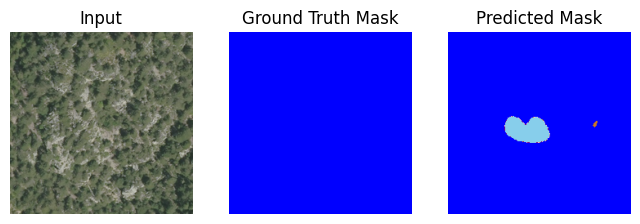

Dice coefficient multilabel of prediction: 0.14081670343875885
1/1 [==============================] - 0s 22ms/step


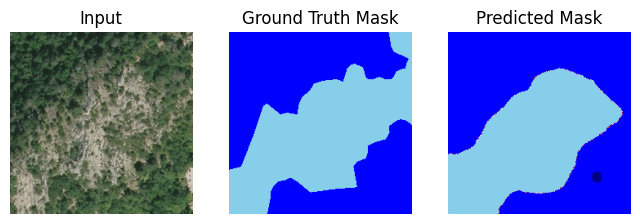

Dice coefficient multilabel of prediction: 0.24993743002414703
1/1 [==============================] - 0s 22ms/step


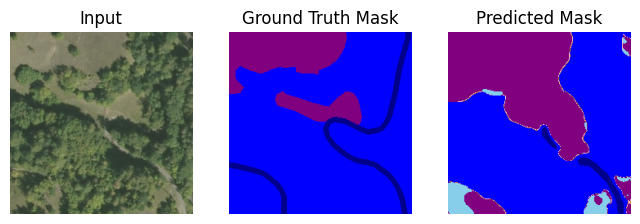

Dice coefficient multilabel of prediction: 0.2536603808403015

Epoch 32: val_dice_coef_multilabel did not improve from 0.55003
300/300 [==============================] - 82s 273ms/step - loss: 0.4599 - dice_coef_multilabel: 0.5661 - accuracy: 0.7864 - val_loss: 0.4901 - val_dice_coef_multilabel: 0.5363 - val_accuracy: 0.7628 - lr: 0.0010
Epoch 33/100
300/300 [==============================] - ETA: 0s - loss: 0.4535 - dice_coef_multilabel: 0.5730 - accuracy: 0.7878
Epoch 33: val_dice_coef_multilabel did not improve from 0.55003
300/300 [==============================] - 80s 268ms/step - loss: 0.4535 - dice_coef_multilabel: 0.5730 - accuracy: 0.7878 - val_loss: 0.5313 - val_dice_coef_multilabel: 0.4956 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 34/100
300/300 [==============================] - ETA: 0s - loss: 0.4548 - dice_coef_multilabel: 0.5724 - accuracy: 0.7894
Epoch 34: val_dice_coef_multilabel did not improve from 0.55003
300/300 [==============================] - 81s 268ms/step - l

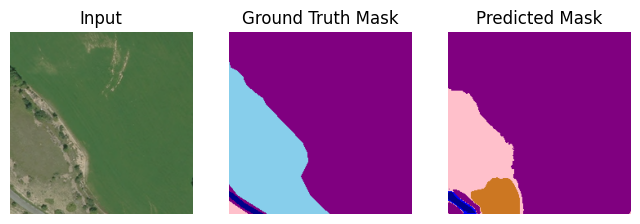

Dice coefficient multilabel of prediction: 0.2560107409954071
1/1 [==============================] - 0s 21ms/step


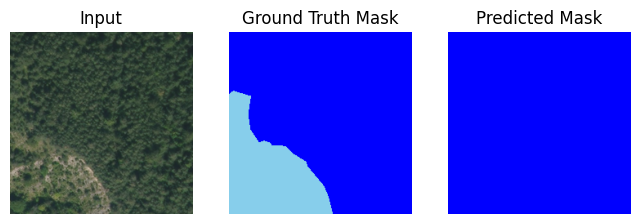

Dice coefficient multilabel of prediction: 0.535854160785675
1/1 [==============================] - 0s 21ms/step


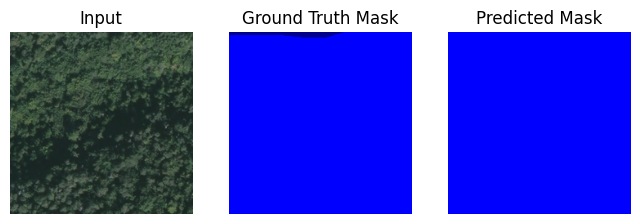

Dice coefficient multilabel of prediction: 0.6915251612663269
1/1 [==============================] - 0s 21ms/step


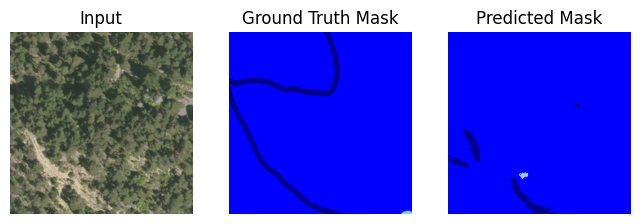

Dice coefficient multilabel of prediction: 0.1805218905210495

Epoch 40: val_dice_coef_multilabel did not improve from 0.56373
300/300 [==============================] - 79s 263ms/step - loss: 0.4475 - dice_coef_multilabel: 0.5815 - accuracy: 0.7913 - val_loss: 0.4807 - val_dice_coef_multilabel: 0.5484 - val_accuracy: 0.7814 - lr: 0.0010
Epoch 41/100
300/300 [==============================] - ETA: 0s - loss: 0.4433 - dice_coef_multilabel: 0.5859 - accuracy: 0.7913
Epoch 41: val_dice_coef_multilabel did not improve from 0.56373
300/300 [==============================] - 80s 265ms/step - loss: 0.4433 - dice_coef_multilabel: 0.5859 - accuracy: 0.7913 - val_loss: 0.4900 - val_dice_coef_multilabel: 0.5392 - val_accuracy: 0.7840 - lr: 0.0010
Epoch 42/100
300/300 [==============================] - ETA: 0s - loss: 0.4530 - dice_coef_multilabel: 0.5771 - accuracy: 0.7902
Epoch 42: val_dice_coef_multilabel did not improve from 0.56373
300/300 [==============================] - 78s 260ms/step - l

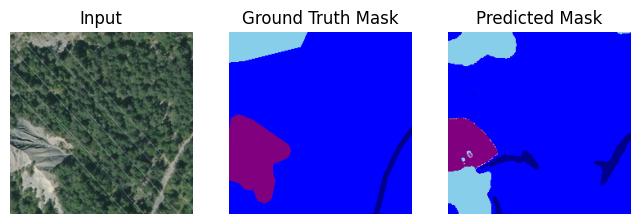

Dice coefficient multilabel of prediction: 0.367705762386322
1/1 [==============================] - 0s 21ms/step


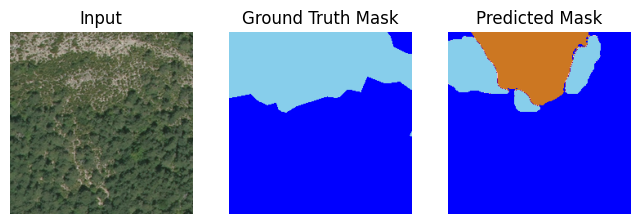

Dice coefficient multilabel of prediction: 0.2012387216091156
1/1 [==============================] - 0s 21ms/step


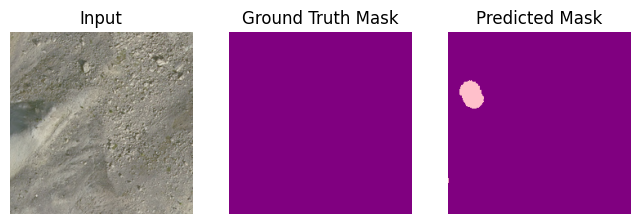

Dice coefficient multilabel of prediction: 0.5693017840385437
1/1 [==============================] - 0s 21ms/step


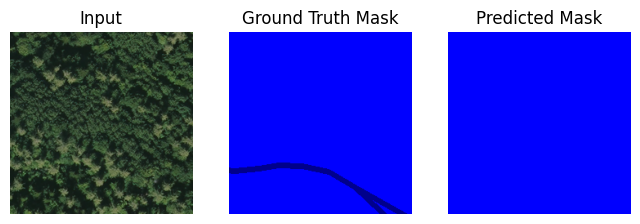

Dice coefficient multilabel of prediction: 0.7096356153488159

Epoch 48: val_dice_coef_multilabel improved from 0.58169 to 0.58224, saving model to ../working/cp.ckpt
300/300 [==============================] - 80s 265ms/step - loss: 0.4302 - dice_coef_multilabel: 0.6013 - accuracy: 0.8036 - val_loss: 0.4491 - val_dice_coef_multilabel: 0.5822 - val_accuracy: 0.8010 - lr: 1.0000e-04
Epoch 49/100
300/300 [==============================] - ETA: 0s - loss: 0.4206 - dice_coef_multilabel: 0.6106 - accuracy: 0.8066
Epoch 49: val_dice_coef_multilabel improved from 0.58224 to 0.59516, saving model to ../working/cp.ckpt
300/300 [==============================] - 78s 260ms/step - loss: 0.4206 - dice_coef_multilabel: 0.6106 - accuracy: 0.8066 - val_loss: 0.4359 - val_dice_coef_multilabel: 0.5952 - val_accuracy: 0.7997 - lr: 1.0000e-04
Epoch 50/100
300/300 [==============================] - ETA: 0s - loss: 0.4169 - dice_coef_multilabel: 0.6141 - accuracy: 0.8049
Epoch 50: val_dice_coef_multilabel di

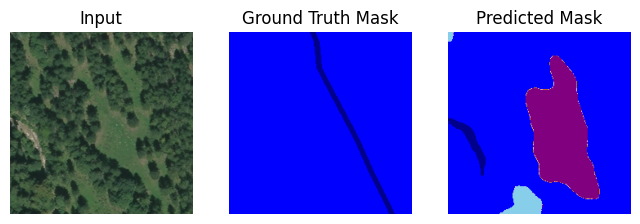

Dice coefficient multilabel of prediction: 0.12509876489639282
1/1 [==============================] - 0s 21ms/step


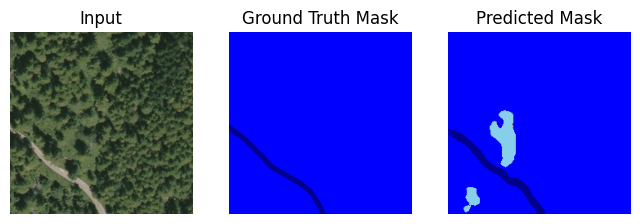

Dice coefficient multilabel of prediction: 0.2503698170185089
1/1 [==============================] - 0s 22ms/step


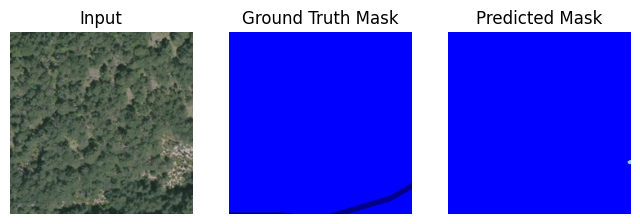

Dice coefficient multilabel of prediction: 0.14227017760276794
1/1 [==============================] - 0s 21ms/step


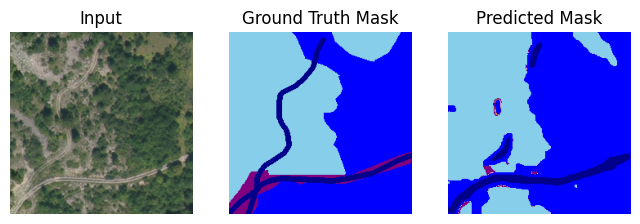

Dice coefficient multilabel of prediction: 0.3317624032497406

Epoch 56: val_dice_coef_multilabel did not improve from 0.59970
300/300 [==============================] - 80s 267ms/step - loss: 0.4060 - dice_coef_multilabel: 0.6236 - accuracy: 0.8127 - val_loss: 0.4334 - val_dice_coef_multilabel: 0.5961 - val_accuracy: 0.8050 - lr: 1.0000e-04
Epoch 57/100
300/300 [==============================] - ETA: 0s - loss: 0.4039 - dice_coef_multilabel: 0.6255 - accuracy: 0.8132
Epoch 57: val_dice_coef_multilabel did not improve from 0.59970
300/300 [==============================] - 78s 259ms/step - loss: 0.4039 - dice_coef_multilabel: 0.6255 - accuracy: 0.8132 - val_loss: 0.4310 - val_dice_coef_multilabel: 0.5984 - val_accuracy: 0.8078 - lr: 1.0000e-04
Epoch 58/100
300/300 [==============================] - ETA: 0s - loss: 0.4057 - dice_coef_multilabel: 0.6236 - accuracy: 0.8133
Epoch 58: val_dice_coef_multilabel did not improve from 0.59970
300/300 [==============================] - 78s 261ms/

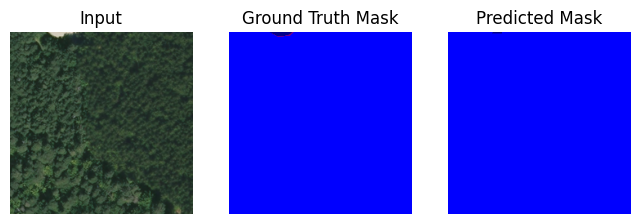

Dice coefficient multilabel of prediction: 0.49089667201042175
1/1 [==============================] - 0s 22ms/step


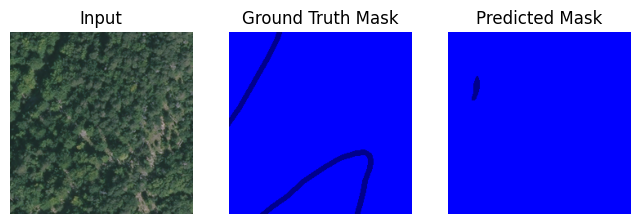

Dice coefficient multilabel of prediction: 0.5770025253295898
1/1 [==============================] - 0s 21ms/step


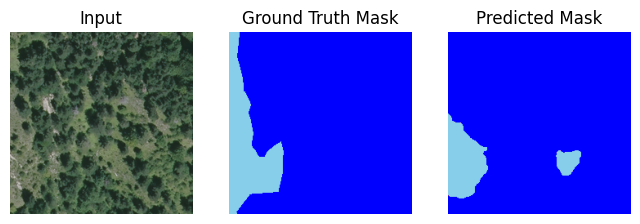

Dice coefficient multilabel of prediction: 0.21857821941375732
1/1 [==============================] - 0s 21ms/step


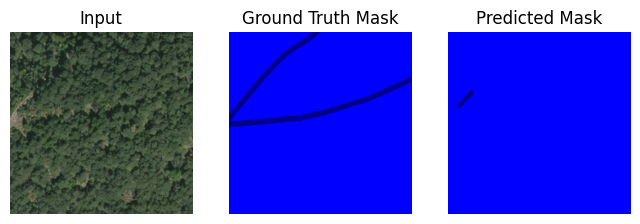

Dice coefficient multilabel of prediction: 0.5838727951049805

Epoch 64: val_dice_coef_multilabel did not improve from 0.60145
300/300 [==============================] - 79s 263ms/step - loss: 0.4001 - dice_coef_multilabel: 0.6283 - accuracy: 0.8145 - val_loss: 0.4398 - val_dice_coef_multilabel: 0.5886 - val_accuracy: 0.8031 - lr: 1.0000e-04
Epoch 65/100
300/300 [==============================] - ETA: 0s - loss: 0.3985 - dice_coef_multilabel: 0.6297 - accuracy: 0.8157
Epoch 65: val_dice_coef_multilabel did not improve from 0.60145
300/300 [==============================] - 81s 270ms/step - loss: 0.3985 - dice_coef_multilabel: 0.6297 - accuracy: 0.8157 - val_loss: 0.4388 - val_dice_coef_multilabel: 0.5894 - val_accuracy: 0.8037 - lr: 1.0000e-04
Epoch 66/100
300/300 [==============================] - ETA: 0s - loss: 0.4020 - dice_coef_multilabel: 0.6261 - accuracy: 0.8157
Epoch 66: val_dice_coef_multilabel did not improve from 0.60145
300/300 [==============================] - 78s 261ms/

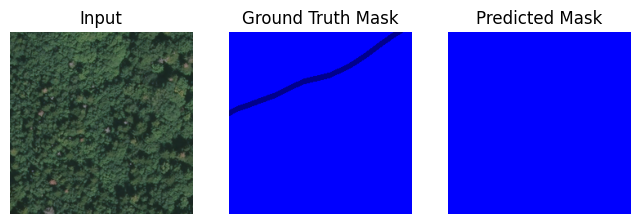

Dice coefficient multilabel of prediction: 0.7099519371986389
1/1 [==============================] - 0s 21ms/step


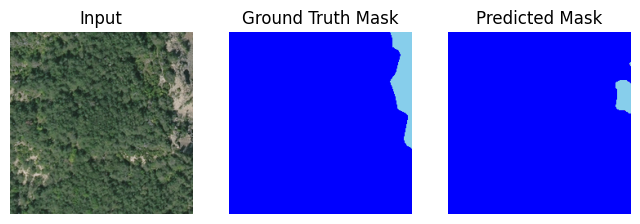

Dice coefficient multilabel of prediction: 0.20258739590644836
1/1 [==============================] - 0s 21ms/step


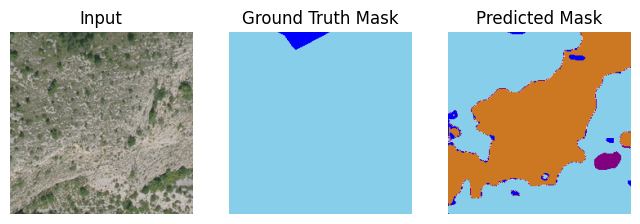

Dice coefficient multilabel of prediction: 0.11890455335378647
1/1 [==============================] - 0s 21ms/step


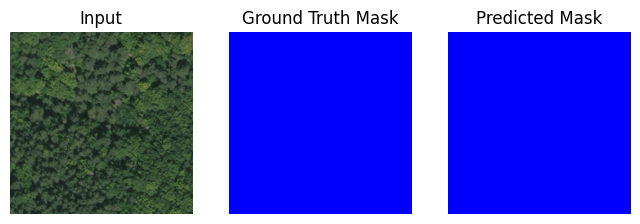

Dice coefficient multilabel of prediction: 0.7126684188842773

Epoch 72: val_dice_coef_multilabel improved from 0.60326 to 0.60650, saving model to ../working/cp.ckpt
300/300 [==============================] - 80s 265ms/step - loss: 0.3910 - dice_coef_multilabel: 0.6368 - accuracy: 0.8178 - val_loss: 0.4213 - val_dice_coef_multilabel: 0.6065 - val_accuracy: 0.8081 - lr: 1.0000e-05
Epoch 73/100
300/300 [==============================] - ETA: 0s - loss: 0.3967 - dice_coef_multilabel: 0.6311 - accuracy: 0.8184
Epoch 73: val_dice_coef_multilabel did not improve from 0.60650
300/300 [==============================] - 80s 266ms/step - loss: 0.3967 - dice_coef_multilabel: 0.6311 - accuracy: 0.8184 - val_loss: 0.4232 - val_dice_coef_multilabel: 0.6047 - val_accuracy: 0.8079 - lr: 1.0000e-05
Epoch 74/100
300/300 [==============================] - ETA: 0s - loss: 0.3941 - dice_coef_multilabel: 0.6337 - accuracy: 0.8185
Epoch 74: val_dice_coef_multilabel did not improve from 0.60650
300/300 [====

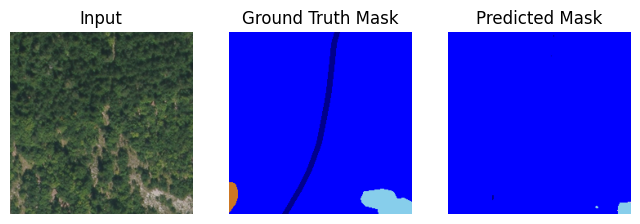

Dice coefficient multilabel of prediction: 0.18051405251026154
1/1 [==============================] - 0s 21ms/step


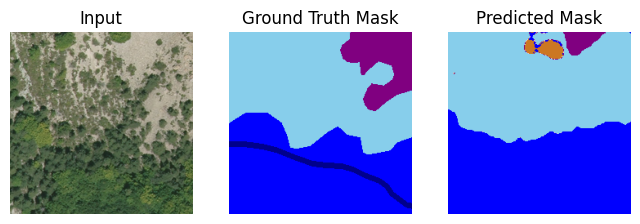

Dice coefficient multilabel of prediction: 0.28431209921836853
1/1 [==============================] - 0s 22ms/step


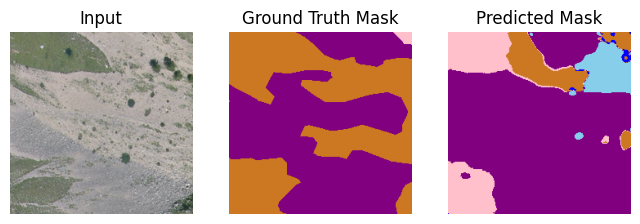

Dice coefficient multilabel of prediction: 0.25242310762405396
1/1 [==============================] - 0s 21ms/step


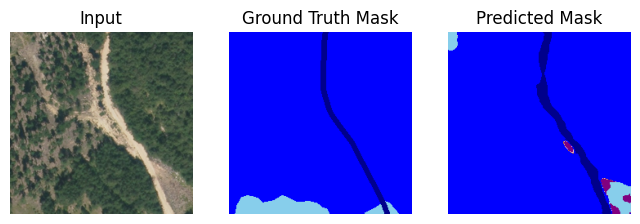

Dice coefficient multilabel of prediction: 0.22298076748847961

Epoch 80: val_dice_coef_multilabel did not improve from 0.60729
300/300 [==============================] - 79s 265ms/step - loss: 0.3950 - dice_coef_multilabel: 0.6328 - accuracy: 0.8189 - val_loss: 0.4234 - val_dice_coef_multilabel: 0.6043 - val_accuracy: 0.8083 - lr: 1.0000e-05
Epoch 81/100
300/300 [==============================] - ETA: 0s - loss: 0.3987 - dice_coef_multilabel: 0.6290 - accuracy: 0.8182
Epoch 81: val_dice_coef_multilabel did not improve from 0.60729
300/300 [==============================] - 78s 259ms/step - loss: 0.3987 - dice_coef_multilabel: 0.6290 - accuracy: 0.8182 - val_loss: 0.4252 - val_dice_coef_multilabel: 0.6025 - val_accuracy: 0.8092 - lr: 1.0000e-05
Epoch 82/100
300/300 [==============================] - ETA: 0s - loss: 0.3957 - dice_coef_multilabel: 0.6320 - accuracy: 0.8200
Epoch 82: val_dice_coef_multilabel did not improve from 0.60729
300/300 [==============================] - 77s 258ms

In [ ]:
history6 = model6.fit(traingen,
            steps_per_epoch = np.ceil(float(len(train_images)) / float(BATCH_SIZE)),
            epochs=100,
            validation_data = valgen,
            validation_steps = np.ceil(float(len(test_images)) / float(BATCH_SIZE)),
            callbacks=callbacks
            )

The model achieved a score of approximately 0.6 on the test set. The early stopping, which was set to halt training within 10 epochs, stopped training after 87 of them. The score curve on the validation set begins to converge as the learning rate starts to decrease.

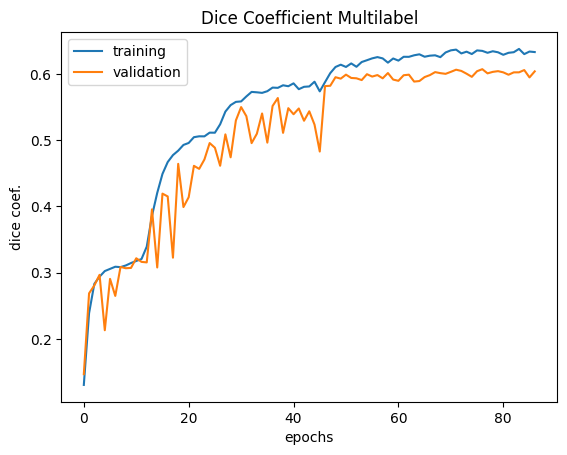

In [ ]:
plt.plot(history6.history['dice_coef_multilabel'])
plt.plot(history6.history['val_dice_coef_multilabel'])
plt.title('Dice Coefficient Multilabel')
plt.ylabel('dice coef.')
plt.xlabel('epochs')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [ ]:
checkpoint_filepath = None
for callback in callbacks:
    if isinstance(callback, ModelCheckpoint):
        checkpoint_filepath = callback.filepath
        break
model6.load_weights(checkpoint_filepath)
model6.evaluate(valgen, verbose=1);

100/100 [==============================] - 19s 193ms/step - loss: 0.4266 - dice_coef_multilabel: 0.6012 - accuracy: 0.8080
